In [2]:
# Import equations
import polarizer_equations as eqns
import sunpy.map
import numpy as np
import matplotlib.pyplot as plt
from sunpy.net import Fido, attrs as a
from astropy.io import fits
%matplotlib notebook
import create_matt_plot as mplt


In [4]:
#read in synthetic data
pBData_synth="./synthDataGamera/PBfor_DOICMEM_00000dens_only_gamera_format_0070.fits"
tBData_synth="./synthDataGamera/TBfor_DOICMEM_00000dens_only_gamera_format_0070.fits"

hdul = fits.open(pBData_synth)
pBdata_synth = hdul[0].data
hdul.close()

hdul = fits.open(tBData_synth)
tBdata_synth = hdul[0].data
hdul.close()
# make the occultor nan's
pBdata_synth[pBdata_synth==-9999.0]=np.nan
tBdata_synth[tBdata_synth==-9999.0]=np.nan

In [6]:
alpha = eqns.alpha_func(2048)

<IPython.core.display.Javascript object>


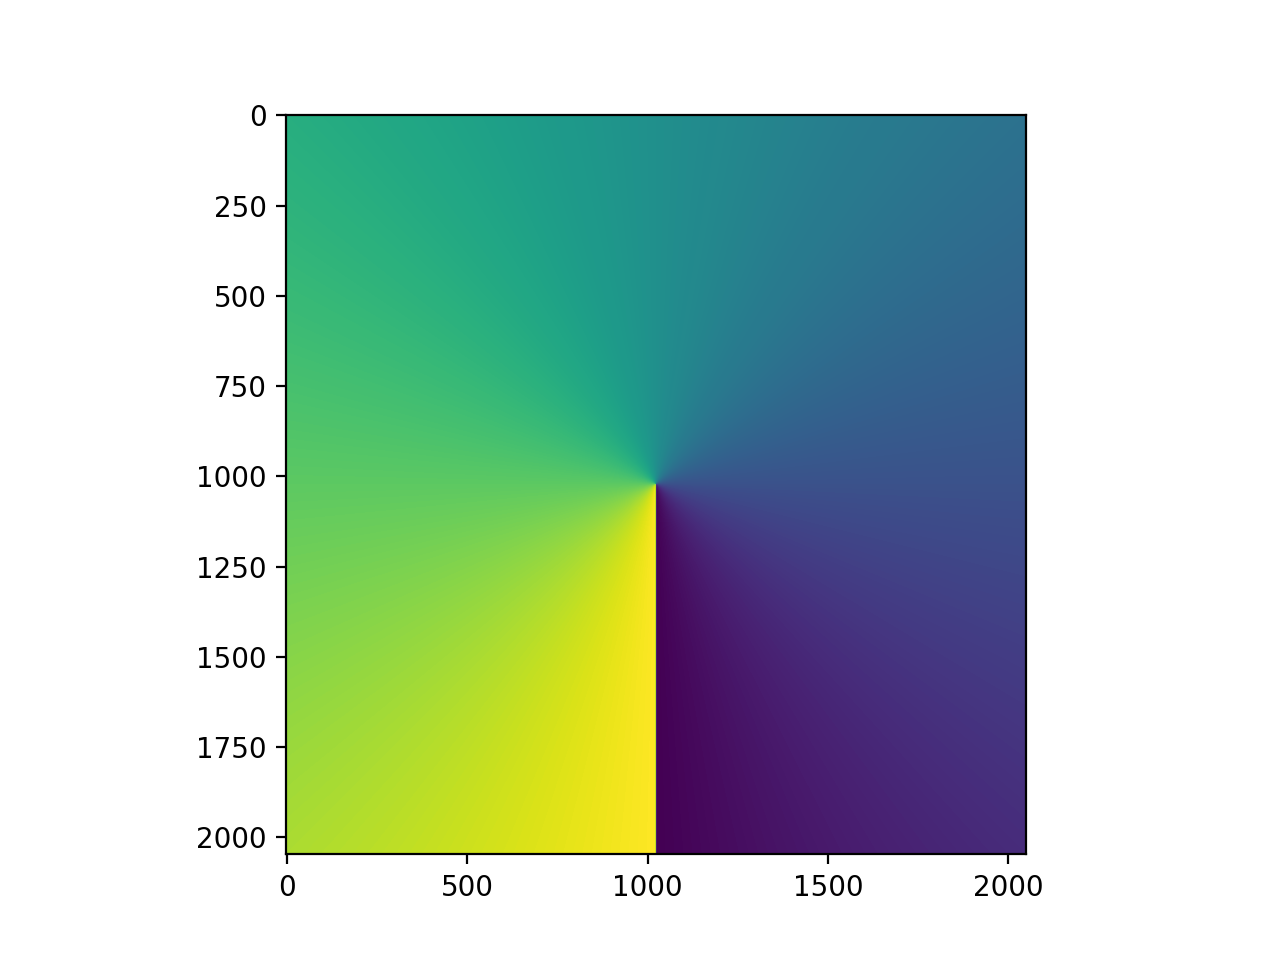

In [134]:
fig, ax = plt.subplots()
ax.imshow(alpha)
fig.show()

In [86]:
def gen_noise(data: np.ndarray = np.zeros([2048, 2048]),
              bias_level: float = 100,
              dark_level: float = 55.81,
              gain: float = 4.3,
              readnoise_level: float = 17,
              bitrate_signal: int = 16) -> np.ndarray:
    """
    Generates noise based on an input data array, with specified noise parameters

    Parameters
    ----------
    data
        input data array (n x n)
    bias_level
        ccd bias level
    dark_level
        ccd dark level
    gain
        ccd gain
    readnoise_level
        ccd read noise level
    bitrate_signal
        desired ccd data bit level

    Returns
    -------
    np.ndarray
        computed noise array corresponding to input data and ccd/noise parameters

    """

    # Generate a copy of the input signal
    data_signal = np.copy(data)

    # Convert / scale data
    # Think of this as the raw signal input into the camera
    data = np.interp(data_signal, (data_signal.min(), data_signal.max()), (0, 2 ** bitrate_signal - 1))
    data = data.astype('long')

    # Add bias level and clip pixels to avoid overflow
    data = np.clip(data + bias_level, 0, 2 ** bitrate_signal - 1)

    # Photon / shot noise generation
    data_photon = data_signal * gain  # DN to photoelectrons
    sigma_photon = np.sqrt(data_photon)  # Converting sigma of this
    sigma = sigma_photon / gain  # Converting back to DN
    noise_photon = np.random.normal(scale=sigma)

    # Dark noise generation
    noise_level = dark_level * gain
    noise_dark = np.random.poisson(lam=noise_level, size=data.shape) / gain

    # Read noise generation
    noise_read = np.random.normal(scale=readnoise_level, size=data.shape)
    noise_read = noise_read / gain  # Convert back to DN

    # Add these noise terms in quadrature if required
    # noise_quad = np.sqrt(noise_photon ** 2 + noise_dark ** 2 + noise_read ** 2)

    # And then add noise terms directly
    noise_sum = noise_photon + noise_dark + noise_read

    return noise_sum, (noise_photon, noise_dark, noise_read)


In [25]:
def before_after_plotter(first, second, vmin, vmax, title):
    fig, axs = plt.subplots(ncols=2, figsize=(8, 5), sharex=True, sharey=True)
    axs[0].imshow(first, vmin=vmin, vmax=vmax)
    axs[0].set_title("Before")
    axs[1].imshow(second, vmin=vmin, vmax=vmax)
    axs[1].set_title("After noise")
    axs[0].set_axis_off()
    axs[1].set_axis_off()
    fig.suptitle(title)
    fig.tight_layout()
    fig.show()


In [174]:
# copy the total and polarized brighness synthetic data
pBdata_synth_copy=pBdata_synth.copy()
tBdata_synth_copy=tBdata_synth.copy()

# convert pB tB to M, Z, P
deg2rad=np.pi/180

Z_synth=eqns.B_theta_double_angle_formula_substitution(tBdata_synth_copy, pBdata_synth_copy, 0*deg2rad, alpha)
M_synth=eqns.B_theta_double_angle_formula_substitution(tBdata_synth_copy, pBdata_synth_copy, 120*deg2rad, alpha)
P_synth=eqns.B_theta_double_angle_formula_substitution(tBdata_synth_copy, pBdata_synth_copy, 240*deg2rad, alpha)

# real data multiplication factor
real_data_factor=1E8

# add noise to M,Z,P data
Z_synth_noise=Z_synth*real_data_factor
Z_synth_just_noise, (photon, dark, read) = gen_noise(Z_synth_noise)
Z_synth_noise = Z_synth_noise+ Z_synth_just_noise
M_synth_noise=M_synth*real_data_factor
M_synth_noise = gen_noise(M_synth_noise)[0]+M_synth_noise
P_synth_noise=P_synth*real_data_factor
P_synth_noise = gen_noise(P_synth_noise)[0]+P_synth_noise

# _, (_, dark, _) = gen_noise(Z_synth*real_data_factor)
# Z_synth_noise = Z_synth_noise - dark
# M_synth_noise = M_synth_noise - dark
# P_synth_noise = P_synth_noise - dark

# create pB and tB from M, Z, P
theta_P=240*deg2rad
theta_Z=0*deg2rad
theta_M=120*deg2rad

# create dictionary of angle:M,Z,P brightness pairs
MZP_Brightness_synth={theta_M:M_synth_noise, theta_P:P_synth_noise, theta_Z:Z_synth_noise}

#use equation 9 to calculate the Brightness
B_synth_out_noise=eqns.B_MZP_sum(MZP_Brightness_synth)
pB_synth_out_noise=eqns.pB_MZP_sum(MZP_Brightness_synth, alpha=alpha)


# create a pB/B ratio plot with synthetic data (no noise)
ratio_pBB=pBdata_synth_copy/tBdata_synth_copy

# create a pB/B ratio plot with noisy data
ratio_pBB_noise=pB_synth_out_noise/B_synth_out_noise

<IPython.core.display.Javascript object>


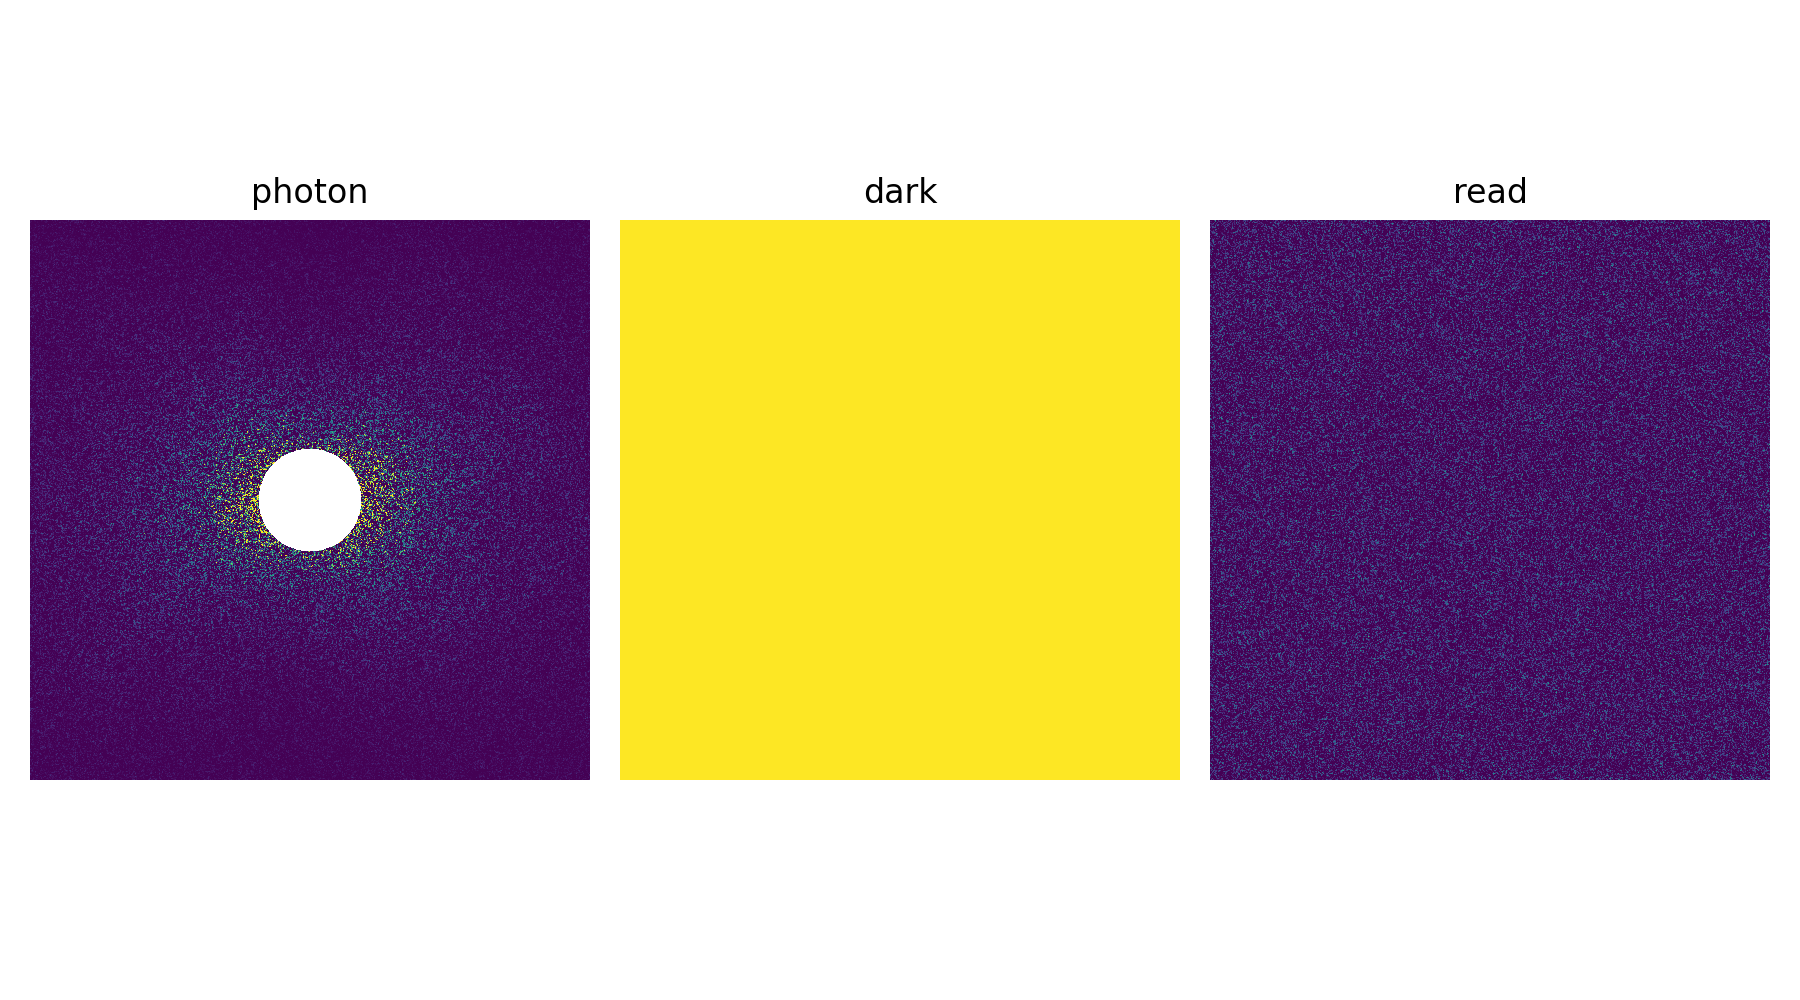

In [148]:
fig, axs = plt.subplots(ncols=3, figsize=(9, 5))

im0 = axs[0].imshow(photon, vmin=0, vmax=5)
axs[0].set_axis_off()
axs[0].set_title("photon")

im1 = axs[1].imshow(dark, vmin=0, vmax=5)
axs[1].set_axis_off()
axs[1].set_title("dark")

im2 = axs[2].imshow(read, vmin=0, vmax=5)
axs[2].set_axis_off()
axs[2].set_title("read")

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


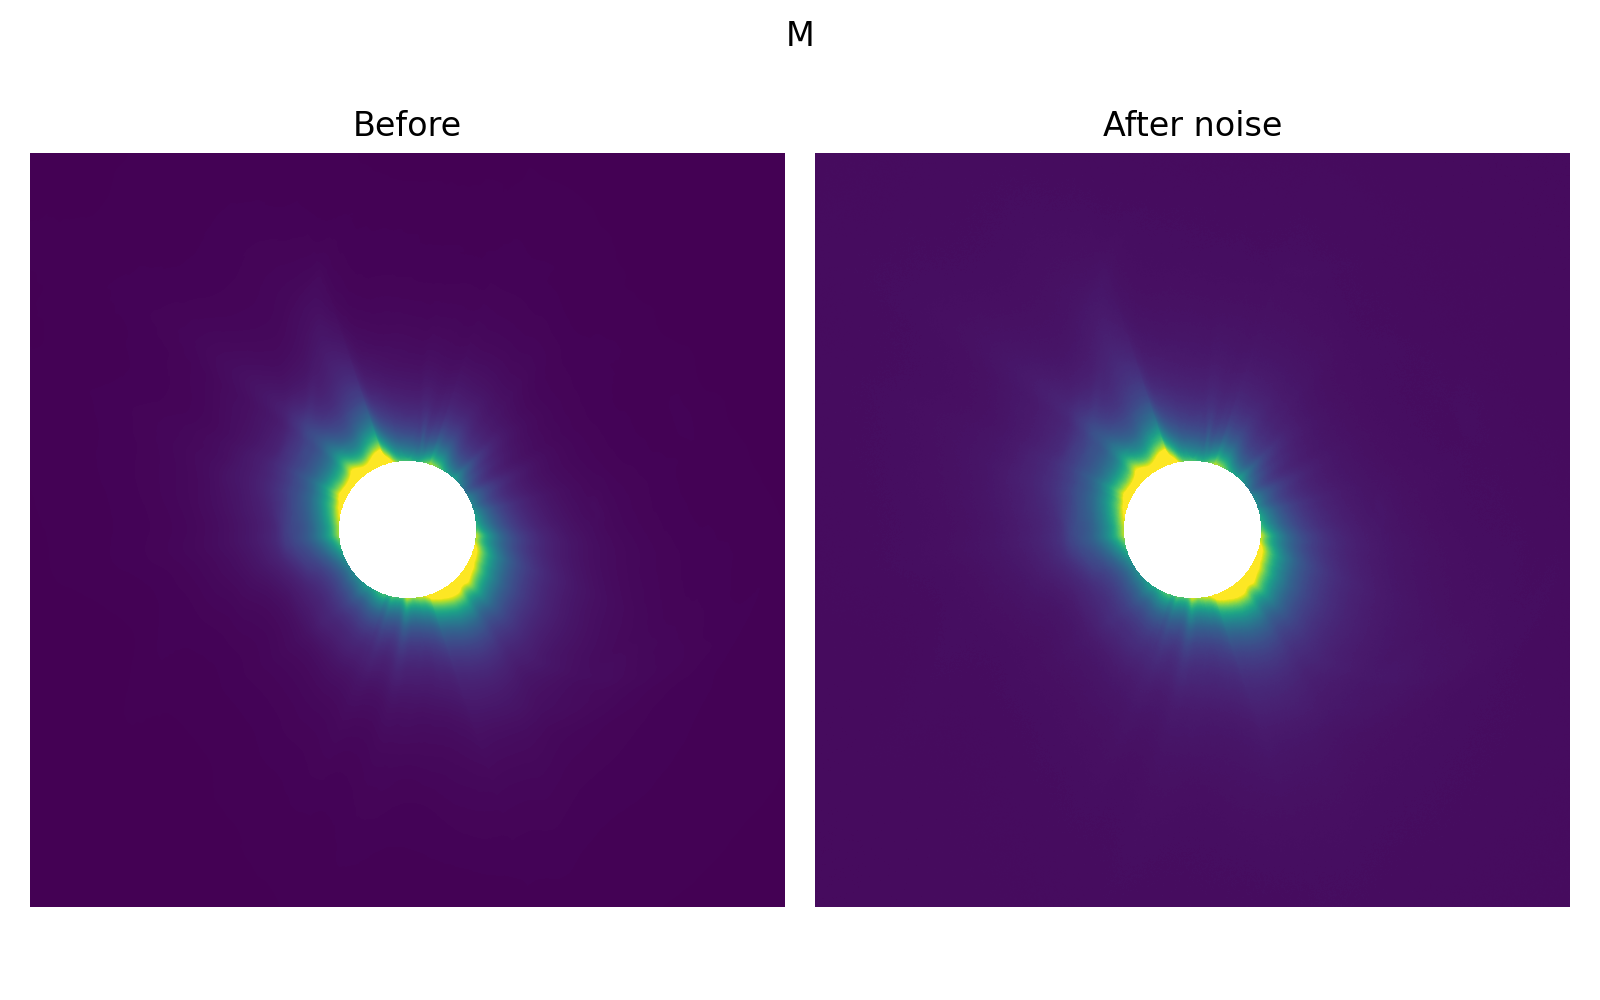

<IPython.core.display.Javascript object>


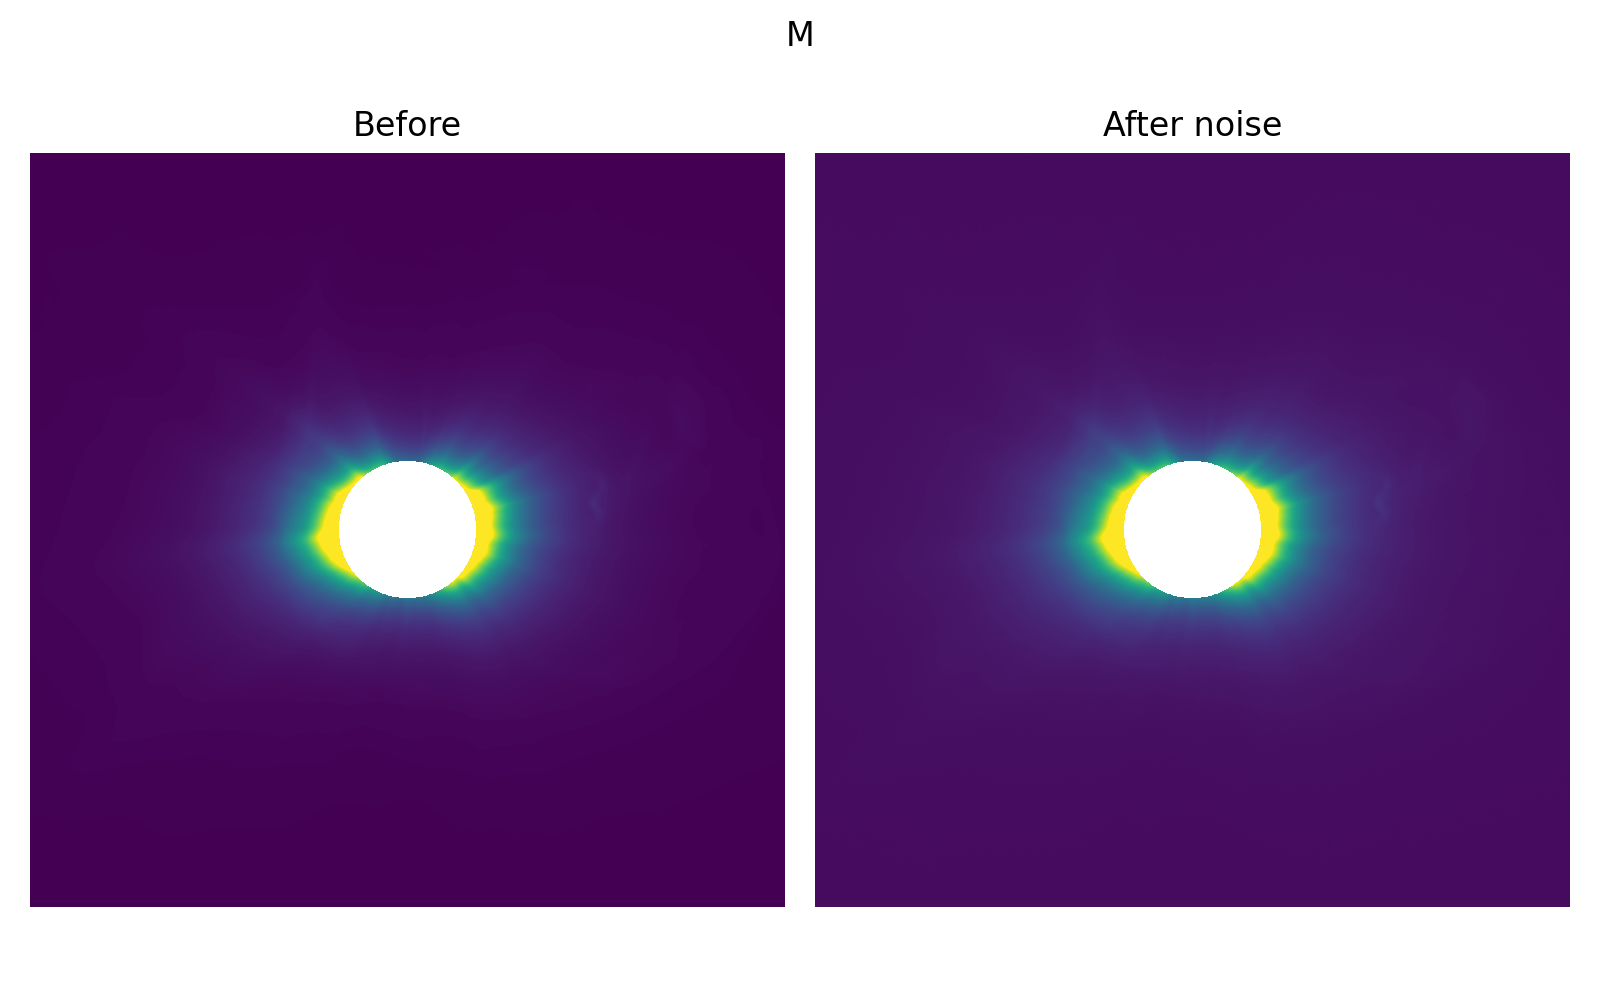

<IPython.core.display.Javascript object>


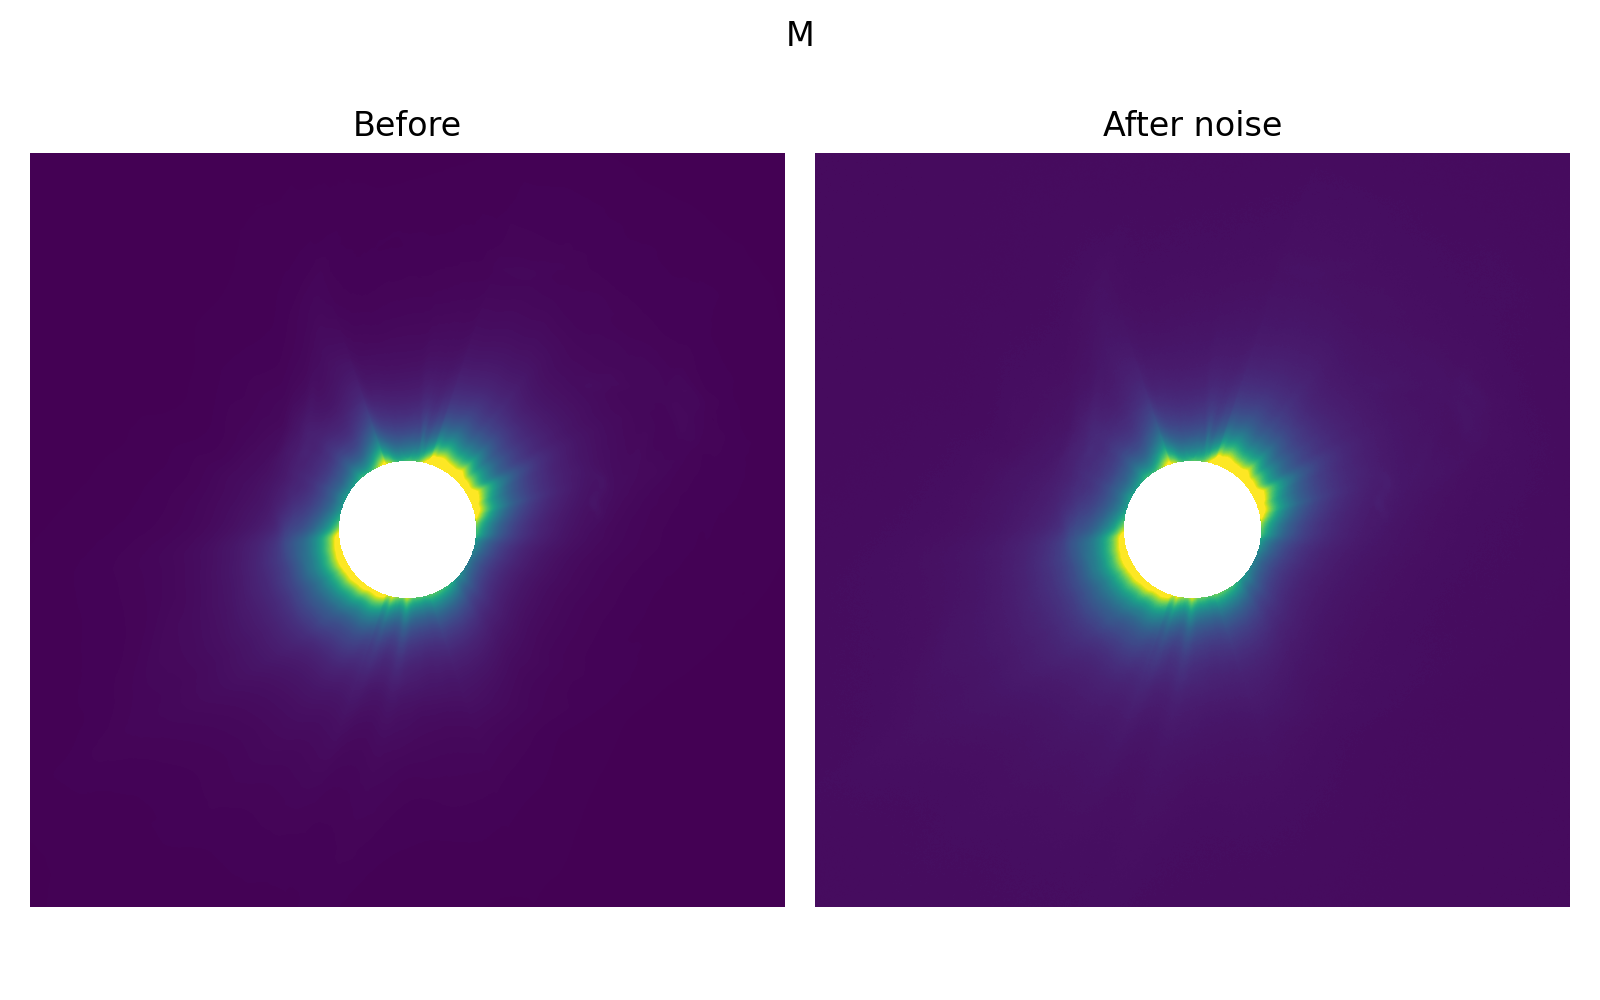

In [149]:
before_after_plotter(M_synth*real_data_factor, M_synth_noise, 0, 2_000, "M")
before_after_plotter(Z_synth*real_data_factor, Z_synth_noise, 0, 2_000, "M")
before_after_plotter(P_synth*real_data_factor, P_synth_noise, 0, 2_000, "M")

In [150]:
np.nanpercentile(tBdata_synth_copy*real_data_factor, 5), np.nanpercentile(tBdata_synth_copy*real_data_factor, 95)

(9.995599605502994, 775.908047893614)

In [151]:
np.nanpercentile(B_synth_out_noise, 5), np.nanpercentile(B_synth_out_noise, 95)

(118.73634044592387, 887.436208094322)

In [152]:
np.nanpercentile(real_data_factor*pBdata_synth_copy, 5), np.nanpercentile(real_data_factor*pBdata_synth_copy, 95)

(6.793741332836864, 419.6880401472622)

In [153]:
np.nanpercentile(pB_synth_out_noise, 5), np.nanpercentile(pB_synth_out_noise, 95)

(-0.10521493306776143, 420.034607831695)

In [172]:
m, z, p = 5000, 4995, 5000
toy_pB = (-4/3) * (m*np.cos(2*(theta_M-alpha)) + z*np.cos(2*(theta_P-alpha)) + p*np.cos(2*(theta_Z-alpha)))

<IPython.core.display.Javascript object>


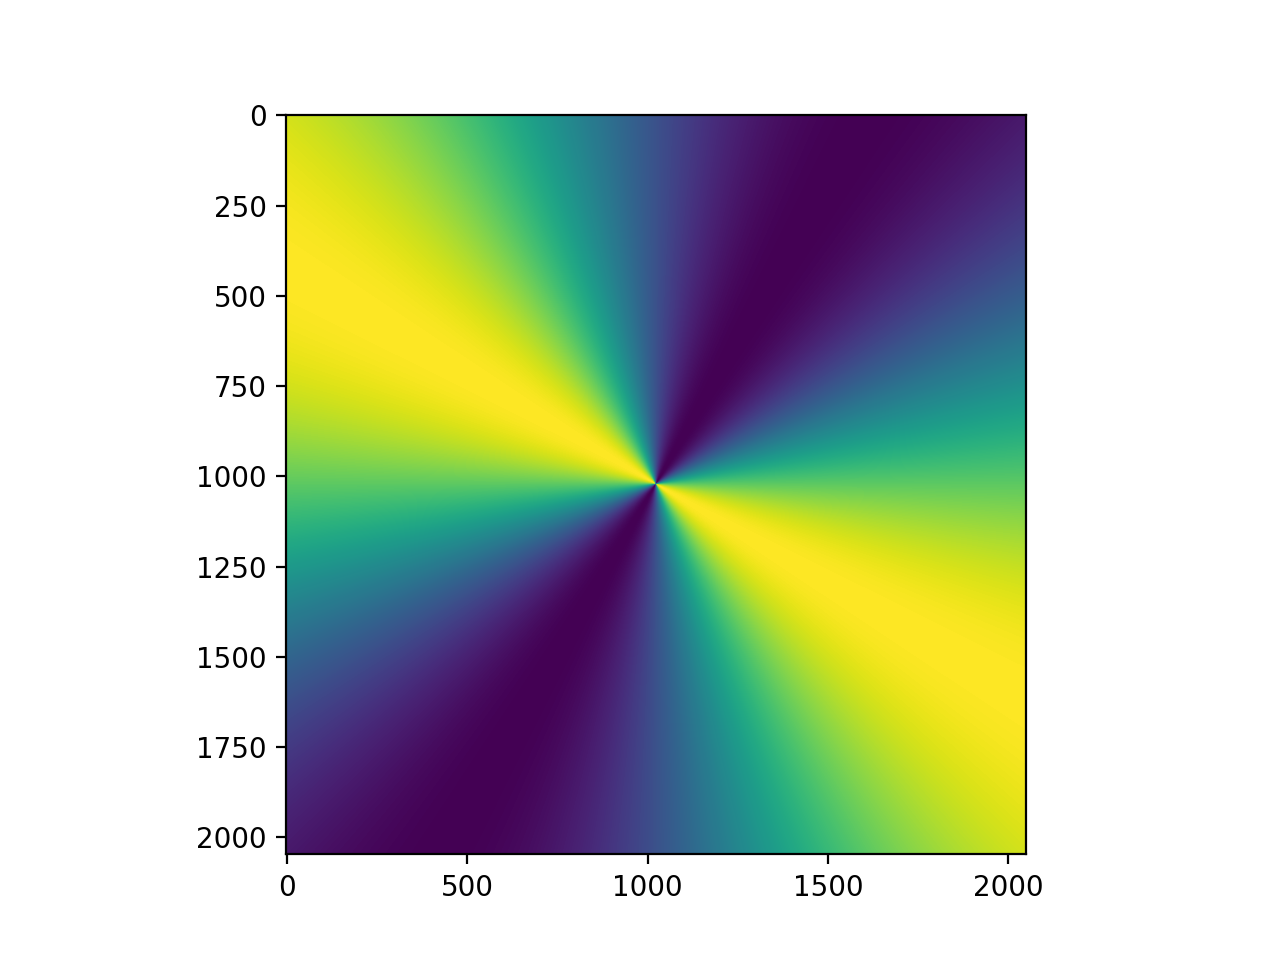

In [173]:
fig, ax = plt.subplots()
ax.imshow(toy_pB)
fig.show()

<IPython.core.display.Javascript object>


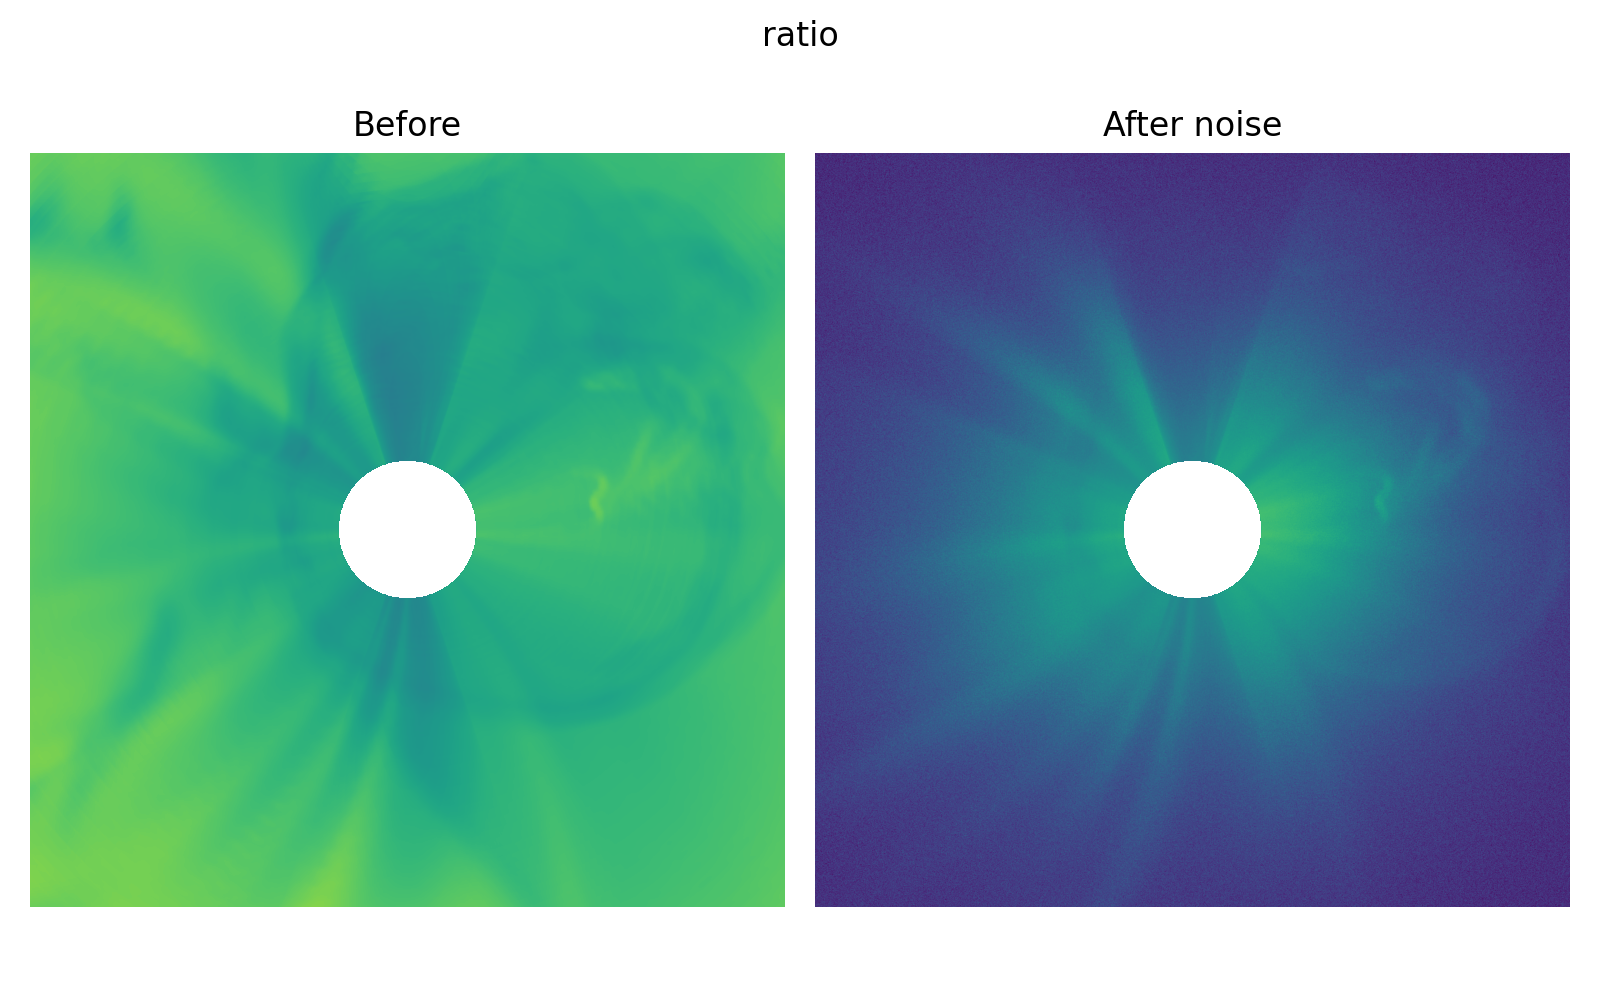

<IPython.core.display.Javascript object>


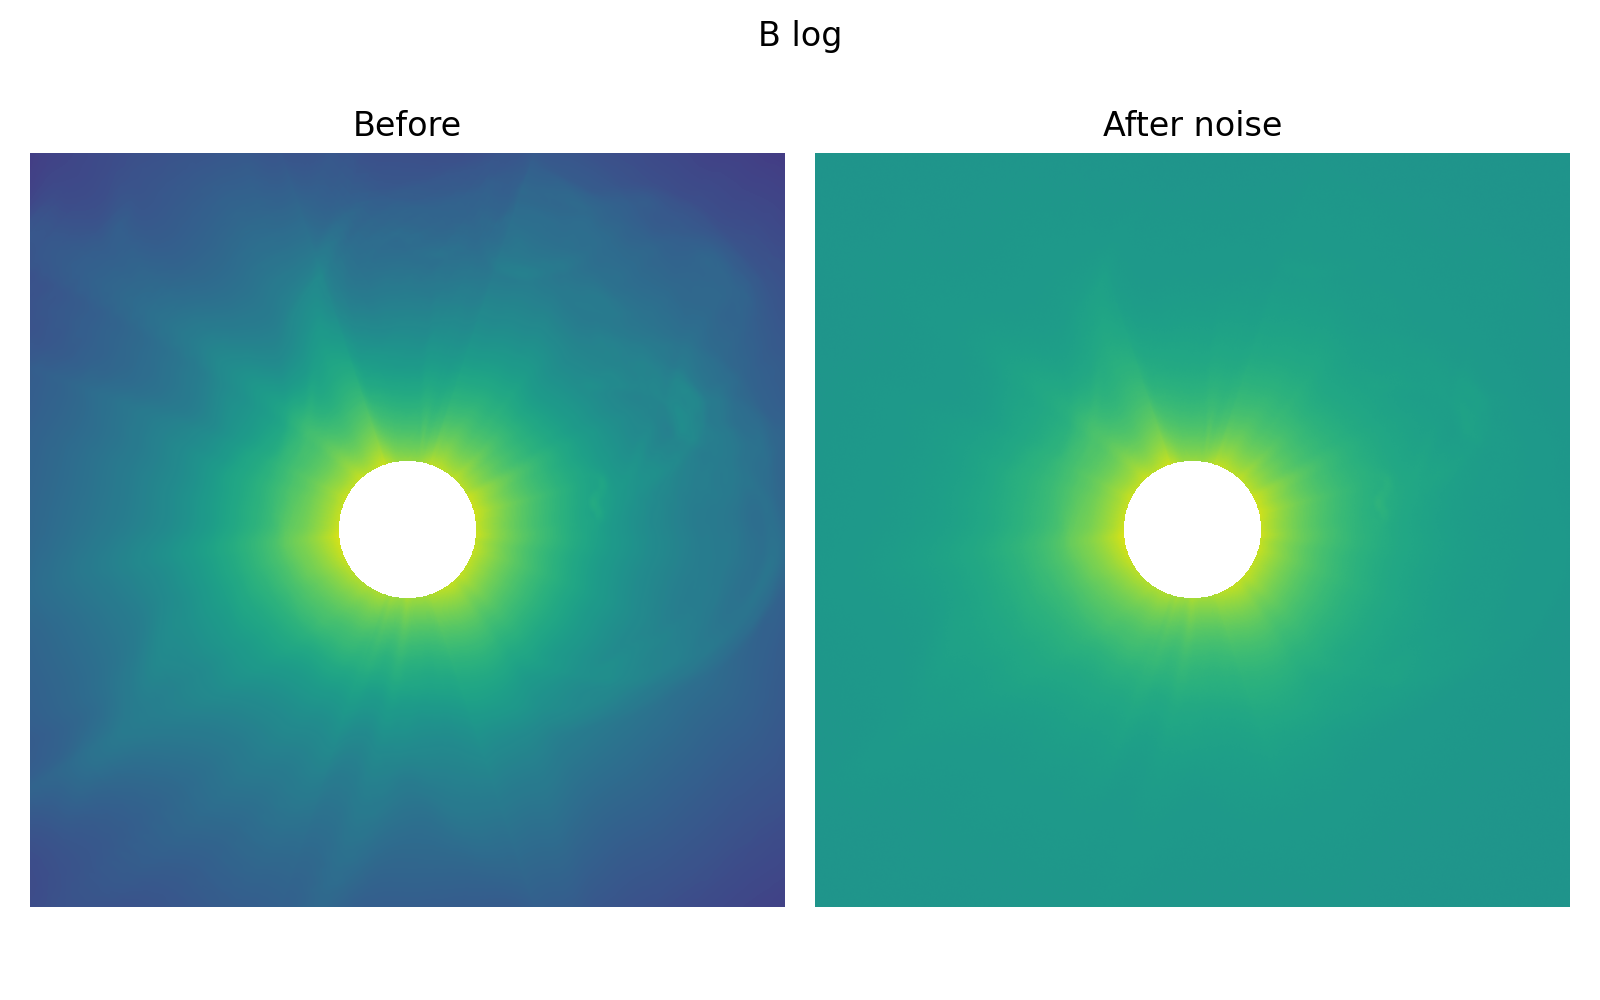

<IPython.core.display.Javascript object>


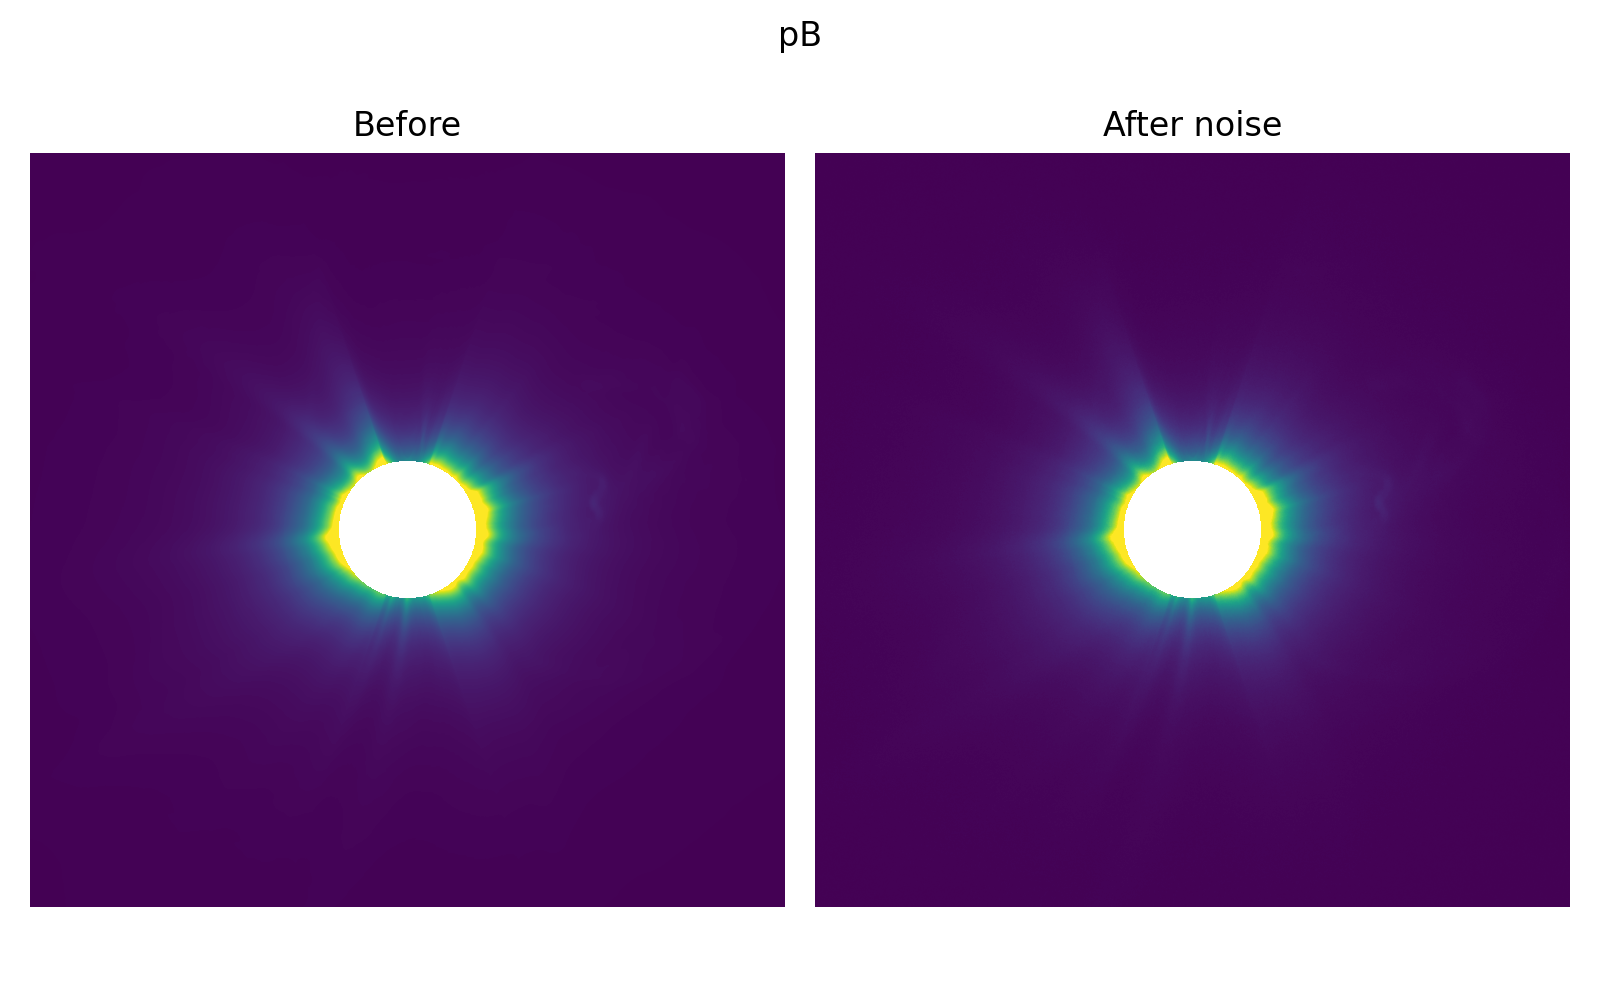

<ipython-input-175-abc5cd33b21f>:4: RuntimeWarning: invalid value encountered in log10
  before_after_plotter(np.log10(pBdata_synth_copy*real_data_factor), np.log10(pB_synth_out_noise), 0, 4, "pB log")


<IPython.core.display.Javascript object>


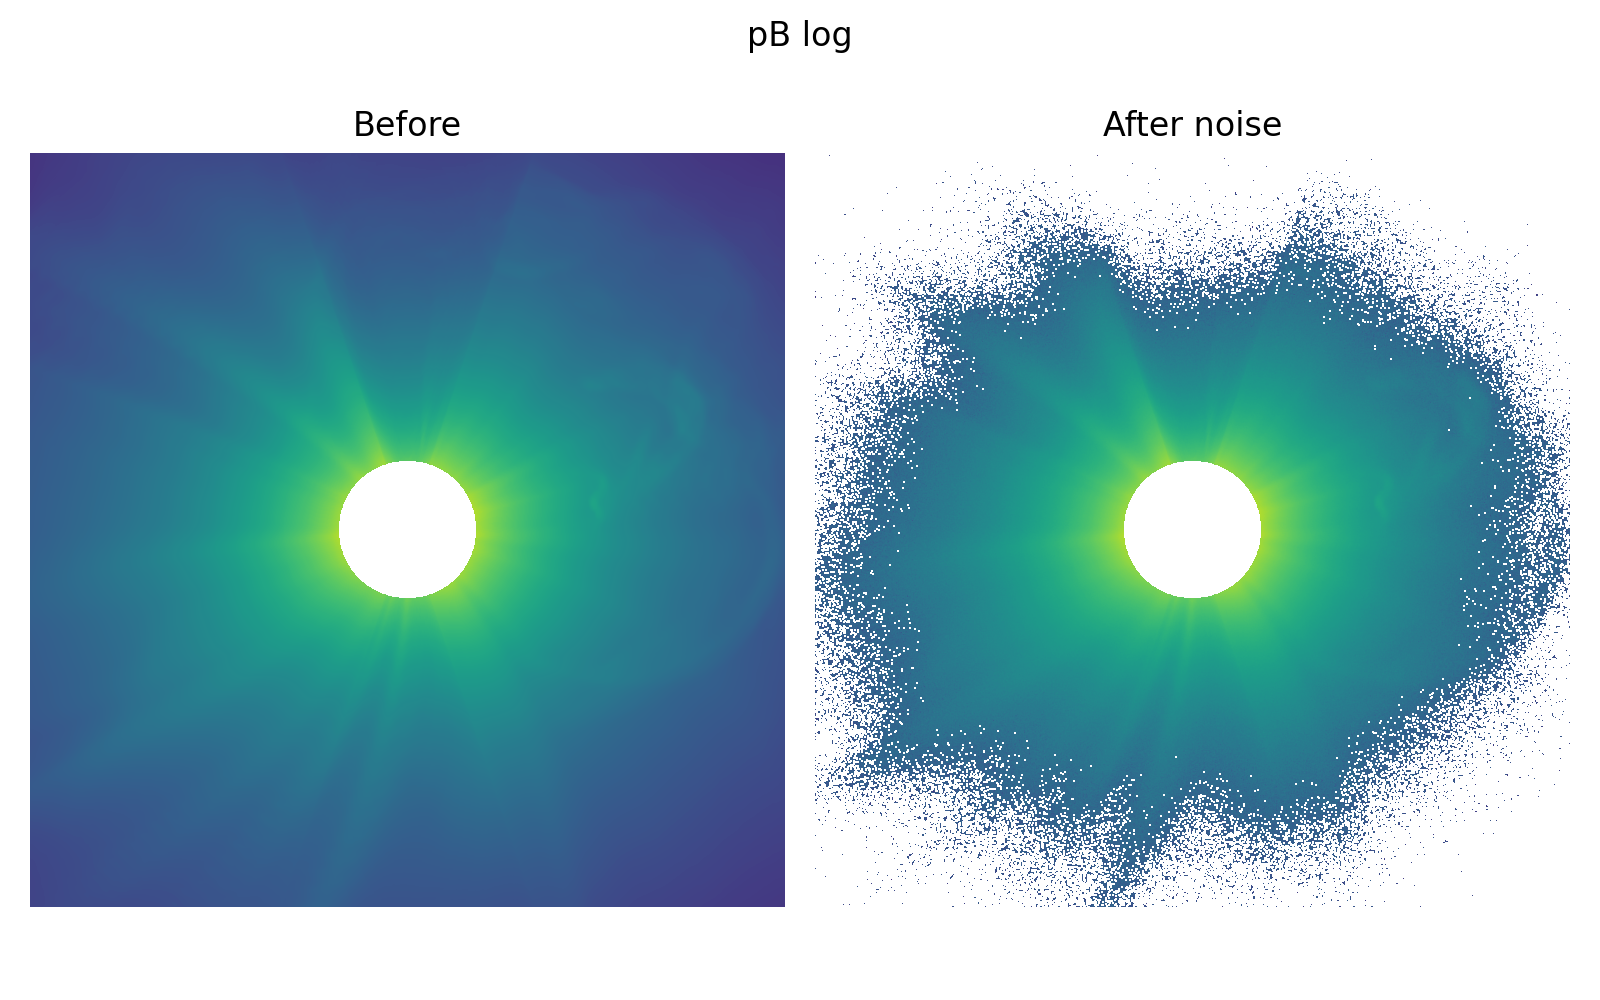

In [175]:
before_after_plotter(ratio_pBB, ratio_pBB_noise, -0.1, 1, "ratio")
before_after_plotter(np.log10(tBdata_synth_copy*real_data_factor), np.log10(B_synth_out_noise), 0, 4, "B log")
before_after_plotter(pBdata_synth_copy*real_data_factor, pB_synth_out_noise, 0, 2_000, "pB")
before_after_plotter(np.log10(pBdata_synth_copy*real_data_factor), np.log10(pB_synth_out_noise), 0, 4, "pB log")

<IPython.core.display.Javascript object>


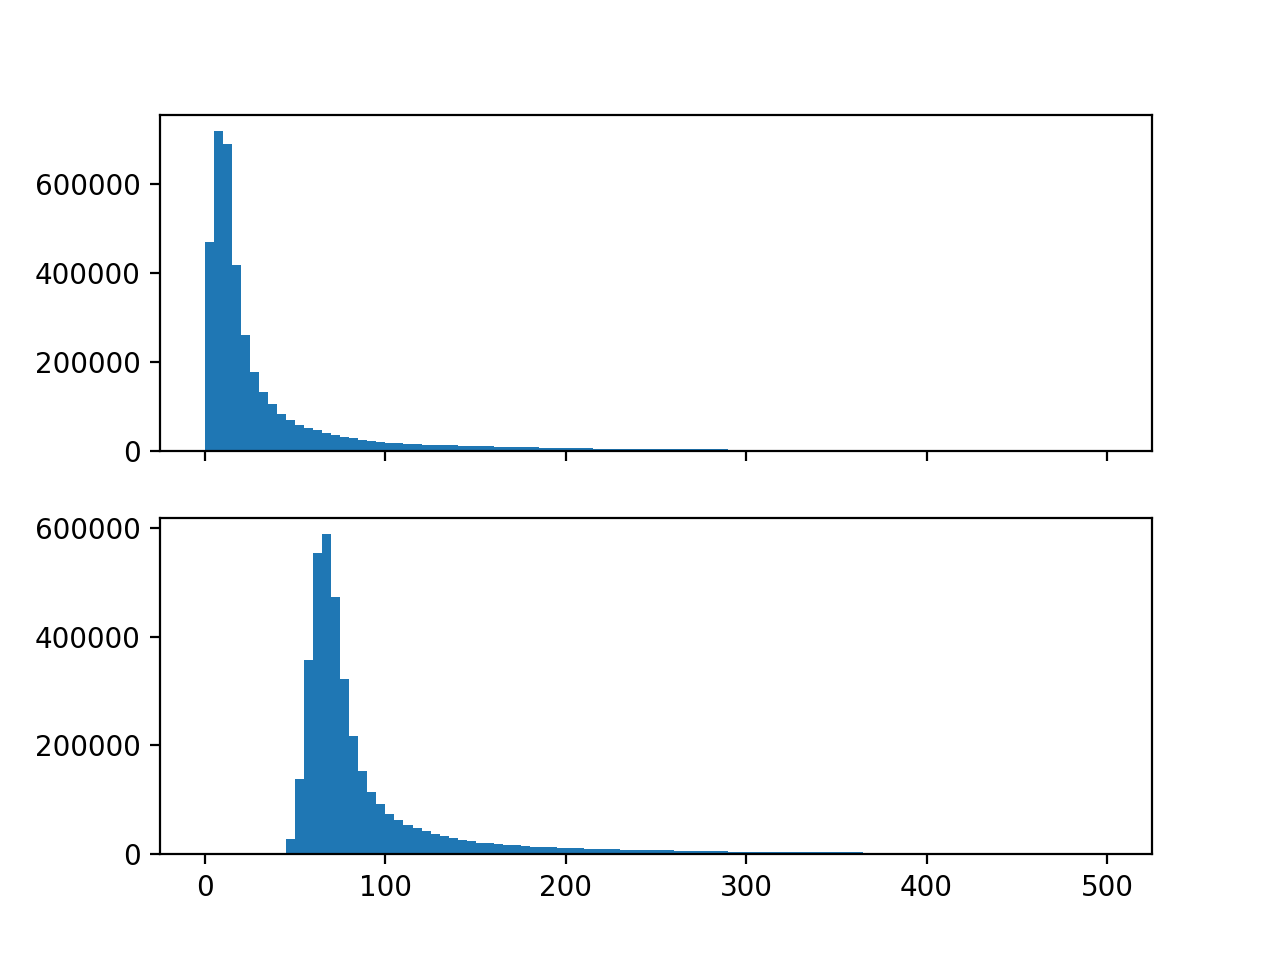

In [157]:
fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].hist(M_synth.ravel()*real_data_factor, 100, range=(0, 500))
axs[1].hist(M_synth_noise.ravel(), 100, range=(0, 500))
fig.show()

<IPython.core.display.Javascript object>


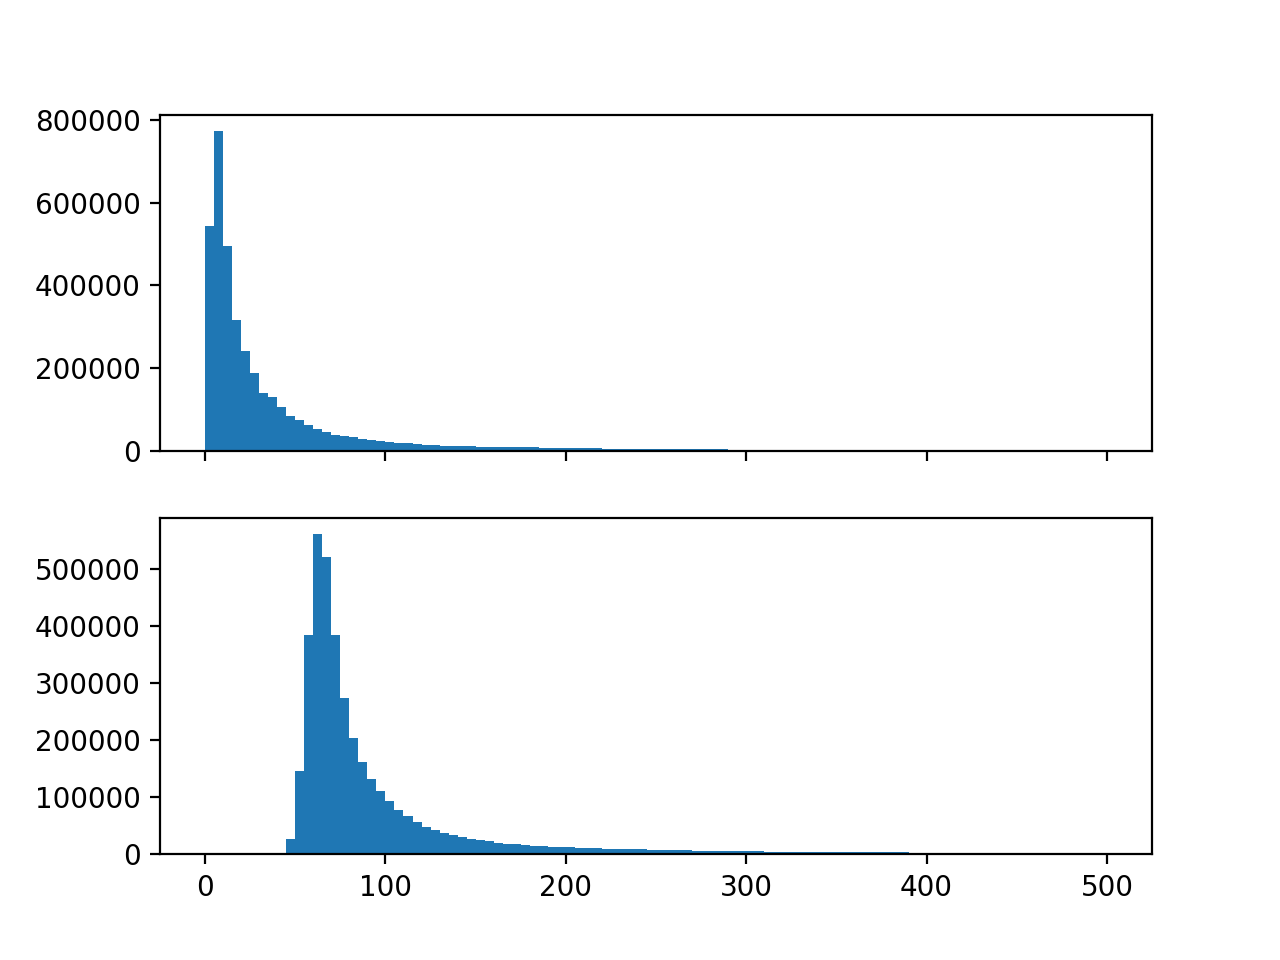

In [65]:
fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].hist(Z_synth.ravel()*real_data_factor, 100, range=(0, 500))
axs[1].hist(Z_synth_noise.ravel(), 100, range=(0, 500))
fig.show()

<IPython.core.display.Javascript object>


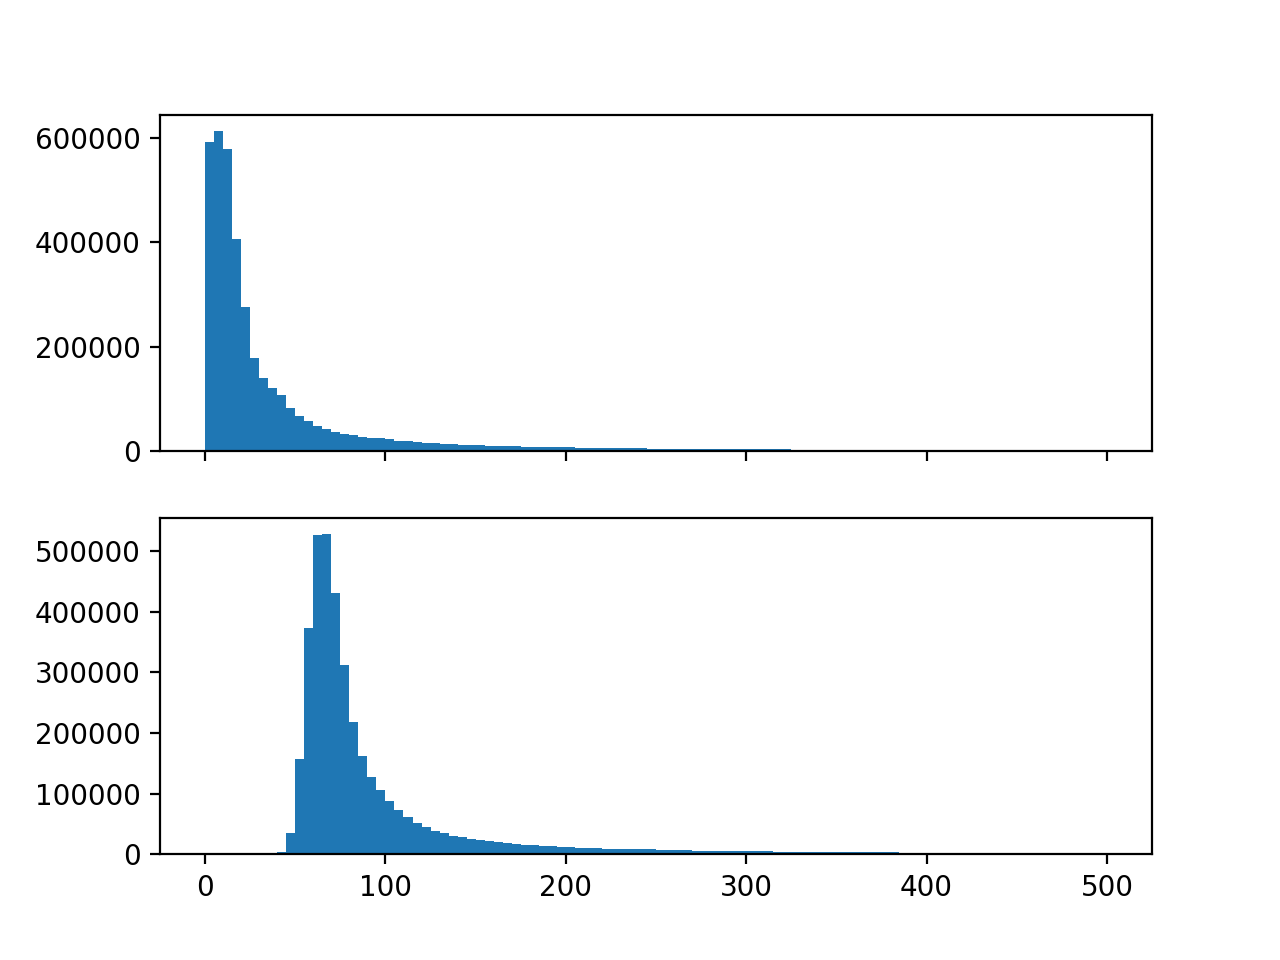

In [66]:
fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].hist(P_synth.ravel()*real_data_factor, 100, range=(0, 500))
axs[1].hist(P_synth_noise.ravel(), 100, range=(0, 500))
fig.show()

<IPython.core.display.Javascript object>


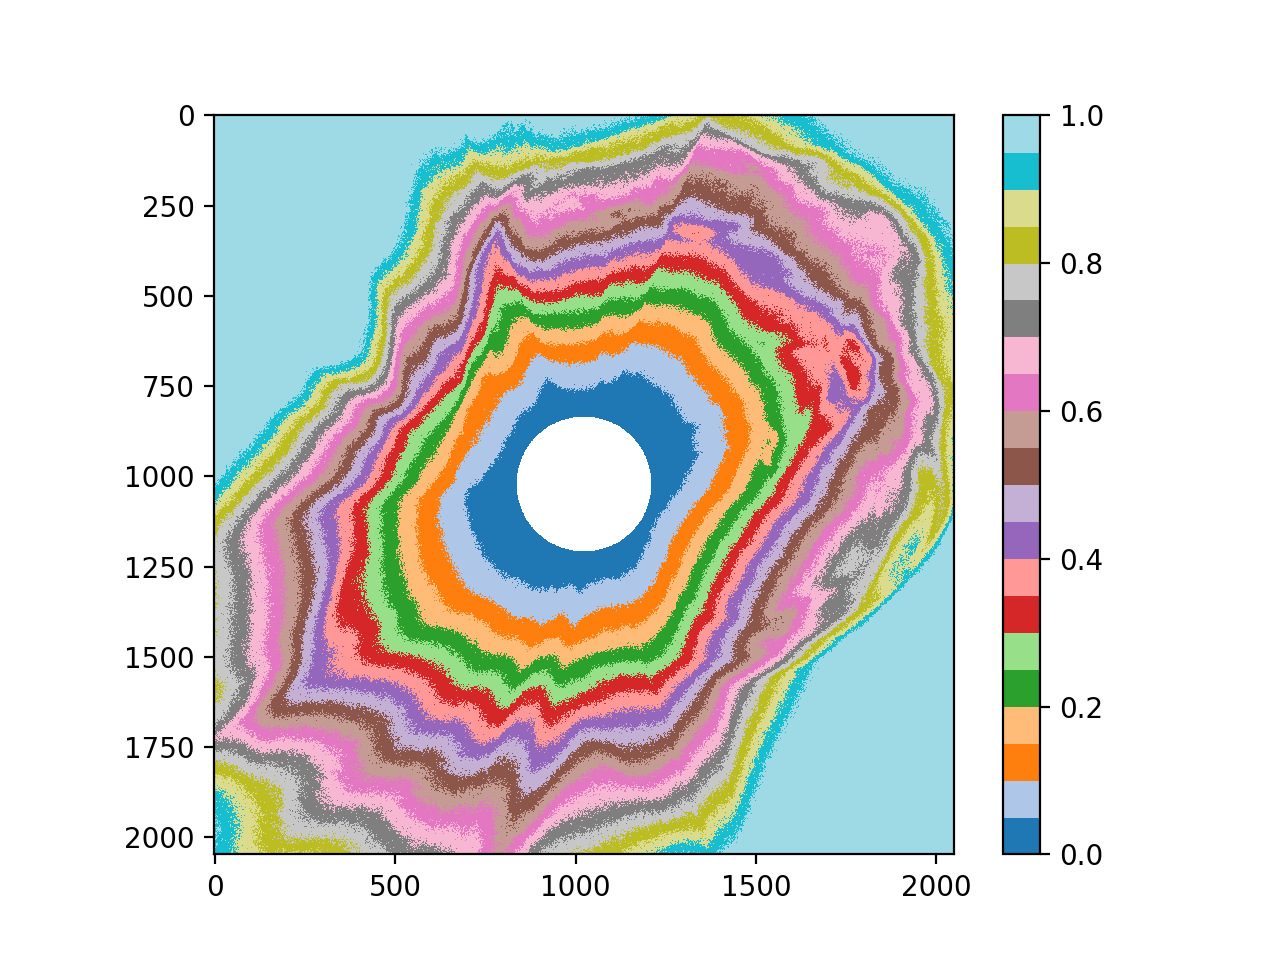

In [83]:
fig, ax = plt.subplots()
im = ax.imshow(np.log10(P_synth_noise/(P_synth*real_data_factor)), vmin=0, vmax=1, cmap='tab20')
fig.colorbar(im)
fig.show()

<IPython.core.display.Javascript object>


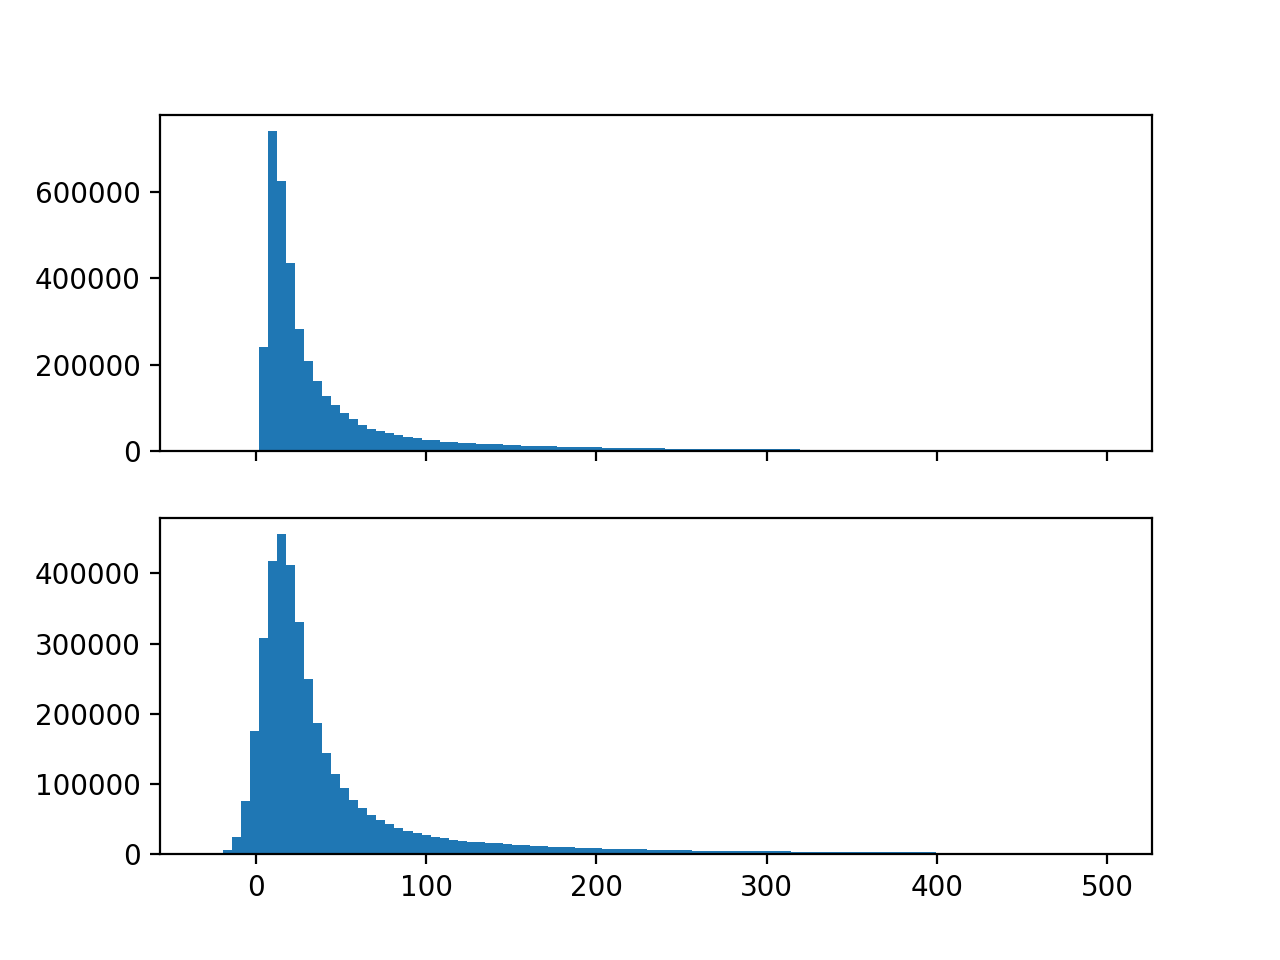

In [70]:
fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].hist(pBdata_synth_copy.ravel()*real_data_factor, 100, range=(-30, 500))
axs[1].hist(pB_synth_out_noise.ravel(), 100, range=(-30, 500))
fig.show()